### imports + functions

In [35]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

In [54]:
def _smooth_1d(x, window):
    if window <= 1:
        return x
    kernel = np.ones(window) / window
    return np.convolve(x, kernel, mode="valid")


def mean_drop_top_frac(df, frac):
    if frac <= 0:
        return df.mean(axis=0)
    q = 1.0 - frac
    return df.where(df.le(df.quantile(q, axis=0)), np.nan).mean(axis=0)


def plot_avg_loss_vs_token_id_with_diff(
    df1,
    df2,
    compare_fns: list[Callable],
    label1="model_1",
    label2="model_2",
    smoothing=1,
    head_trim=0,
    tail_trim=0,
    drop_outliers=0.0,
    figsize=None,
):
    """
    df1, df2: pandas DataFrames of shape (num_rows, seq_len)
    """

    avg1 = mean_drop_top_frac(df1, frac=drop_outliers).to_numpy()
    avg2 = mean_drop_top_frac(df2, frac=drop_outliers).to_numpy()


    # trim
    if tail_trim > 0:
        avg1 = avg1[head_trim:-tail_trim]
        avg2 = avg2[head_trim:-tail_trim]
    else:
        avg1 = avg1[head_trim:]
        avg2 = avg2[head_trim:]

    # smooth
    avg1 = _smooth_1d(avg1, smoothing)
    avg2 = _smooth_1d(avg2, smoothing)

    token_ids = np.arange(len(avg1)) + head_trim

    if figsize is None:
        figsize = (12, 4 + 1.5 * len(compare_fns))
    
    nrows = 1 + len(compare_fns)
    height_ratios = [8] + [3] * len(compare_fns)

    fig, ax = plt.subplots(
        nrows, 1,
        figsize=figsize,
        sharex=True,
        gridspec_kw={"height_ratios": height_ratios},
    )

    # top: both models
    ax[0].set_title(f"{label1} - {label2}")
    ax[0].plot(token_ids, avg1, label=label1)
    ax[0].plot(token_ids, avg2, label=label2)
    ax[0].set_ylabel("Average loss")
    ax[0].legend()

    for i, compare_fn in enumerate(compare_fns):
        diff, ylabel = compare_fn(avg1, avg2)

        ax[i + 1].plot(token_ids, diff, label=f"{label1} − {label2}")
        ax[i + 1].set_xlabel("Token ID")
        ax[i + 1].set_ylabel(ylabel)

    plt.tight_layout()
    plt.show()


### plot

In [62]:
grid_folder = "/home/janek/Downloads/lr_grid/csvs"

# filename1 = "dmodel=1024+kv_heads=16+dff=2560+learning_rate=10+model_seed=123+data_seed=123.csv"
# label1 = "MHA+lr=10+dff=2560"

# filename2 = "dmodel=1024+kv_heads=1+dff=3520+learning_rate=10+model_seed=123+data_seed=123.csv"
# label2 = "MQA+lr=10+dff=3520"

filename1 = "dmodel=1024+kv_heads=1+dff=3840+learning_rate=12+model_seed=123+data_seed=123.csv"
label1 = "MQA+lr=12+dff=3840"

filename2 = "dmodel=1024+kv_heads=1+dff=3200+learning_rate=12+model_seed=123+data_seed=123.csv"
label2 = "MQA+lr=12+dff=3200"

MHA_PATH = os.path.join(grid_folder, filename1)
MQA_PATH = os.path.join(grid_folder, filename2)
df_mha = pd.read_csv(MHA_PATH)
df_mqa = pd.read_csv(MQA_PATH)

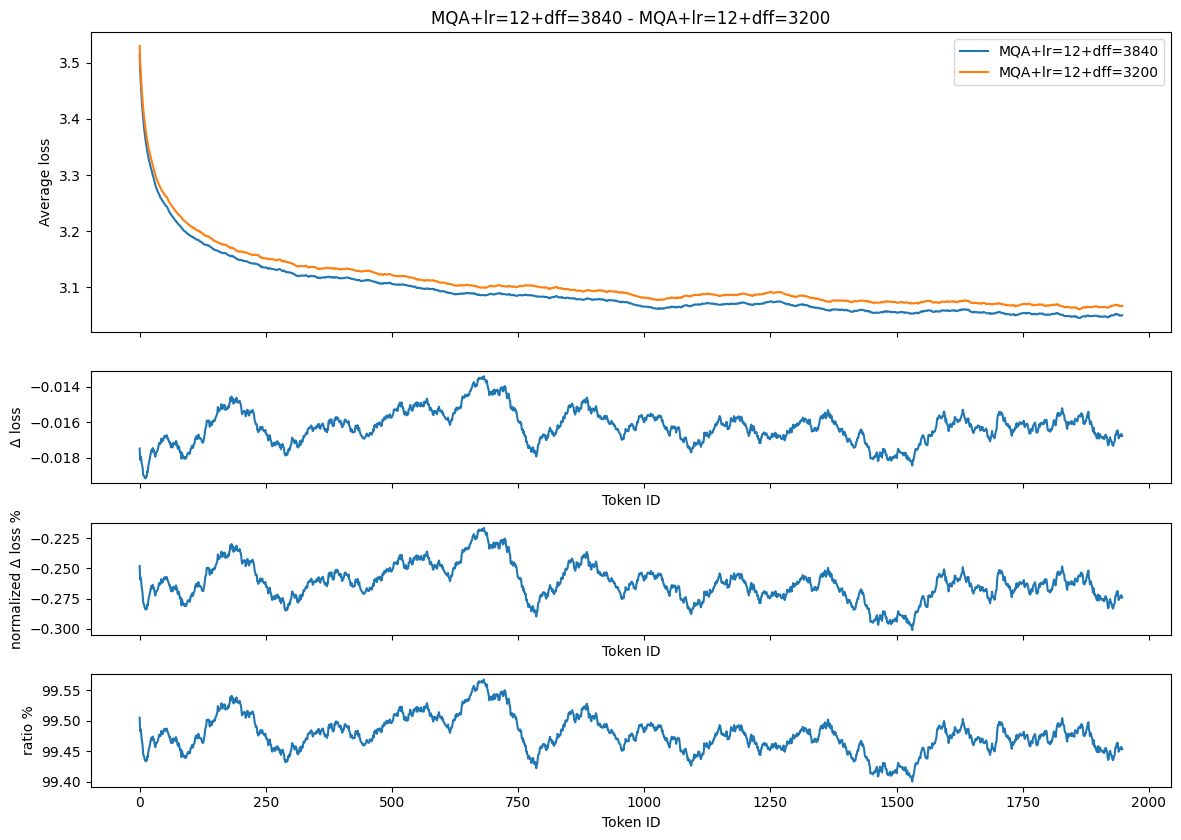

In [ ]:
def diff(a, b):
    return a - b, "Δ loss"

def norm_diff(a, b):
    return (a - b) * 100 / (a + b), "normalized Δ loss %"

def ratio(a, b):
    return a * 100 / b, "ratio %"

plot_avg_loss_vs_token_id_with_diff(
    df1=df_mha,
    df2=df_mqa,
    compare_fns=[diff, norm_diff, ratio],
    label1=label1,
    label2=label2,
    head_trim=0,
    tail_trim=0,
    smoothing=100,
    drop_outliers=0.0,
)